We extract video frames from selected animations and extract
the line art images to form our training dataset. We calculate a
**768-dimensional feature vector of histograms of R, G, B channels
for each frame**. The difference between frames is determined by
calculating the **mean square error** of the feature vectors, which
is used for splitting the source animations into shots. When the
difference between the neighboring frames is **greater than 200**, it
is considered to belong to different shots. In order to improve the
quality of the data, we **remove shots in which the mean square
errors between all pairs of frames are less than 10** (as they are
too uniform), and **the shot with a length less than 8 frames**.
Then we **filter out video frames that are too dark or too faded
in color**. Finally we get a total of 
1096 video sequences from 6 animations, with a total of 29,834 images. 
Each video sequence
has 27 frames on average. 

In [23]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import glob
import json
import os
import shutil
import pandas as pd
from skimage.metrics import structural_similarity
from PIL import Image
from pathlib import Path
from scipy.ndimage.filters import gaussian_filter
from torchvision import transforms

Let's create the frames.

In [ ]:
def VidToFrames_2 (vidpath, folderName):
    vidcap = cv2.VideoCapture(vidpath)
    success,image = vidcap.read()
    count = 0
    length = int(vidcap.get(cv2.CAP_PROP_FPS))
    width  = int(vidcap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(vidcap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    print(length, width, height)
    while success:
        resized = cv2.resize(image, (256,256), interpolation = cv2.INTER_AREA)
        cv2.imwrite("{}/{}.png".format(folderName, str(count).zfill(5)), resized)  
        success,image = vidcap.read()
        count += 1
    print(count, "frames in file")

def VidToFrames (vidpath, folderName):
    vidcap = cv2.VideoCapture(vidpath)
    success,image = vidcap.read()
    print(success)
    count = 0
    length = int(vidcap.get(cv2.CAP_PROP_FPS))
    width  = int(vidcap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(vidcap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    print(length, width, height)
    while success:
        cv2.imwrite("{foldername}/{frameNum}.png".format(foldername= folderName, frameNum=str(count)), image)  
        success,image = vidcap.read()
        count += 1
    print(count, "frames in file")

# for i in glob.glob("mp4/*.mp4")[1:]:
#     print(i)
#     destination = i.split('.mp4')[0].split('-',1)[-1]
#     os.mkdir(destination)
#     VidToFrames_2(i, destination)

Now that we have folders with frames from each video for each channelId, we can start the analysis. There is two parts to this: 
1. Color analysis
2. Motion analysis

### Part I  <br/>
***Color Analysis*** <br/>
Is there a correlation between color and subcount?

In [12]:
def getFeatureVectorOfImage_color (imagePath):
    image = cv2.imread(imagePath)
    vectors = []
    for i, col in enumerate(['b', 'g', 'r']):
        hist = cv2.calcHist([image], [i], None, [256], [0, 256])
        vectors.append(hist)
        # plt.plot(hist, color = col)
        # plt.xlim([0, 256])
    # plt.show()
    vectors = np.vstack(vectors)
    return vectors

def getFeatureVectorOfImage (imagePath):
    image = cv2.imread(imagePath)
    vectors = []
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])
    vectors = np.vstack(hist)
    return vectors

def MSE_images (f1_v, f2_v, listOfMse): #small changes are even smaller, big changes are even bigger. 
    mse = np.sum(np.square(np.subtract(f1_v, f2_v))) / (256*256)
    listOfMse.append(mse)
    return mse

from IPython.display import Image, display
def non_whiteBlack_ratio(imagePath):
    img = cv2.imread(imagePath, 0)
    # display(Image(filename=imagePath) )
    print(img)
    number_of_white_pix = np.sum(img == 255)
    number_of_black_pix = np.sum(img == 0)
    number_of_pix = np.sum(img != None)
    print(number_of_white_pix, number_of_black_pix, number_of_pix)
    colorPercentage = (256**2-number_of_black_pix-number_of_white_pix)/ number_of_pix
    return colorPercentage

# non_whiteBlack_ratio("frames/_uk_6vfqwTA/00032.png")
# non_whiteBlack_ratio("frames/_uk_6vfqwTA/00317.png")
# non_whiteBlack_ratio("frames/_uk_6vfqwTA/22317.png")
# non_whiteBlack_ratio("frames/_uk_6vfqwTA/23772.png")
# non_whiteBlack_ratio("purered.png")
non_whiteBlack_ratio("why_white.png")

vidId_to_colorPercentage = {}
videosToAnalyze = glob.glob("frames/*")

for i in range(len(videosToAnalyze)):
    frames = glob.glob(videosToAnalyze[i]+'/*')
    ratio = non_whiteBlack_ratio(frames[0])
    for j in range(1,len(frames)):
        ratio = (ratio+ non_whiteBlack_ratio(frames[j]))/2
    vidId_to_colorPercentage[videosToAnalyze[i].split('/')[-1]]= ratio


[[237 238 238 ... 237 238 238]
 [238 237 237 ... 238 238 237]
 [237 238 238 ... 237 237 237]
 ...
 [174 174 174 ... 174 174 174]
 [174 174 174 ... 174 174 174]
 [174 174 174 ... 174 174 174]]
0 0 2056600


In [2]:
# with open('vidId_to_colorPercentage.json', 'w') as output:
#     json.dump(vidId_to_colorPercentage_2, output)
with open('vidId_to_colorPercentage.json') as input:
    vidId_to_colorPercentage_2 = json.load(input)

vidId_to_colorPercentage_2

{'Mv8OkBjySGQ': 0.756790293531353,
 '2yFCyPX3kT0': 0.2561283613553745,
 'OyDLuom4KGs': 0.7951050395089434,
 'RlU32AfEVeU': 0.8425037665168975,
 '2juKkLxdQo0': 0.8179510207763561,
 'KwkhpOJ6nQ4': 0.9095575784438148,
 'uDvPIKM-L1o': 0.7840301040162381,
 '2bGkEK8I6zQ': 0.2816923043995375,
 'IwxWmKsVR5U': 0.2906264818816604,
 'I9uWUw1fxOY': 0.9987279313030298,
 'Xnv7JGqjaAo': 0.9909235093306703,
 'EcgkRp2IUsc': 0.9999617173264206,
 '_uk_6vfqwTA': 0.6549719456586,
 'cZ_CnLE6SPo': 0.12965399030675862,
 'Vm6Yu2N-ePI': 0.9928727765355149,
 'gA0bi-bFEYs': 0.9999956331758624,
 'O0hyjRF6quc': 0.815034020420276,
 '6wS_uON5s6Q': 0.856823215893194,
 'kQEtRoyFfI8': 0.9986455562824764,
 'o0zjRGRYEhk': 0.9834406641553878,
 'vv2vPAzj8S4': 0.9492102091639986,
 '5pMckBGWzAY': 0.9994652024535167,
 'Hkz0NcKPzMs': 0.20983775516025072,
 'n4CAhXpyVCI': 0.29270846403657147,
 '0Vxp_Lj2b-E': 0.7760715644650616,
 'nHgRnjqLmtM': 0.9410319343321591,
 'A6V1QujNz8s': 0.12569424985985816,
 'eNGgfPs0Xp8': 0.279749870328

In [3]:
# with open('vidIdToMseColor.json', 'w') as output:
#     json.dump(vidId_to_Mse, output)
with open('vidIdToMseColor.json') as input:
    data = json.load(input)
data

{'Mv8OkBjySGQ': 120626.5625,
 '2yFCyPX3kT0': 1989.3287353515625,
 'OyDLuom4KGs': 17404.6328125,
 'RlU32AfEVeU': 66172.3046875,
 '2juKkLxdQo0': 63559.0625,
 'KwkhpOJ6nQ4': 142605.84375,
 'uDvPIKM-L1o': 36439.4296875,
 '2bGkEK8I6zQ': 2072.5224609375,
 'IwxWmKsVR5U': 3708.1015625,
 'I9uWUw1fxOY': 137186.1875,
 'Xnv7JGqjaAo': 82502.6328125,
 'EcgkRp2IUsc': 144177.78125,
 '_uk_6vfqwTA': 55987.96484375,
 'cZ_CnLE6SPo': 799.7706909179688,
 'Vm6Yu2N-ePI': 275551.46875,
 'gA0bi-bFEYs': 142279.96875,
 'O0hyjRF6quc': 77446.1484375,
 '6wS_uON5s6Q': 31204.533203125,
 'kQEtRoyFfI8': 55762.7265625,
 'o0zjRGRYEhk': 57655.94921875,
 'vv2vPAzj8S4': 146546.21875,
 '5pMckBGWzAY': 62979.62109375,
 'Hkz0NcKPzMs': 344.64862060546875,
 'n4CAhXpyVCI': 604.8108520507812,
 '0Vxp_Lj2b-E': 71367.875,
 'nHgRnjqLmtM': 40783.9609375,
 'A6V1QujNz8s': 284.62591552734375,
 'eNGgfPs0Xp8': 15938.1318359375,
 'oKLbOxLJfRg': 128.04006958007812,
 'rlSXaDq3uOk': 7445.2880859375,
 'so1_5hYUEE8': 4838.1962890625,
 'de8PRd_d7kg'

In [3]:
def binAndPlot(some_list):
    sorted_list = sorted(some_list)
    sorted_counted = Counter(sorted_list)
    range_length = list(range(int(max(some_list)+1))) # Get the largest value to get the range.
    data_series = {}

    for i in range_length:
        data_series[i] = 0 # Initialize series so that we have a template and we just have to fill in the values.
    for key, value in sorted_counted.items():
        data_series[key] = value
    data_series = pd.Series(data_series)
    x_values = data_series.index
    plt.hist(some_list, edgecolor="yellow", color="green")
    plt.show()

### Part 2:
*** Motion Analysis ***

Is there a correlation between the amount of animation and subcount?

In my head, I should technically analyze how much each frame differs from each other. 
However, color is a value that is assigned to each pixel in a frame.

So we are going to get rid of color. We're not completely getting rid of it tho- any changes due to color will be detected (example)- because we are using
ahem ahem an eXtended difference-of-Gaussians to extract the lines. So we're basically changing the data to put less weight on color because it's already been accounted for in Part I.

 There was a time when I was interested in colorization machine learning techniques. Honestly, I still am, just less than this project. 

 There was a paper called [Deep Line Art Video Colorization with a Few References](https://arxiv.org/abs/2003.10685) that I spent some time generating data for. It was only after I generated all the data that I realized I don't have the resources (GPU, money, honestly, motivation was the biggest factor)

> We extract video frames from selected animations and extract
the line art images to form our training dataset. We calculate a
768-dimensional feature vector of histograms of R, G, B channels
for each frame. The difference between frames is determined by
calculating the mean square error of the feature vectors, which
is used for splitting the source animations into shots. When the
difference between the neighboring frames is greater than 200, it
is considered to belong to different shots. In order to improve the
quality of the data, we remove shots in which the mean square
errors between all pairs of frames are less than 10 (as they are
too uniform), and the shot with a length less than 8 frames.
Then we filter out video frames that are too dark or too faded
in color. Finally we get a total of 1096 video sequences from 6
animations, with a total of 29,834 images. Each video sequence
has 27 frames on average. 

In my case, I got around 28k iumages with 32 frames per scene on average.

I'm going to use the data collection method stated above, with a slight variation


In [4]:
with open('../channelId_to_mostViewedVidId.json', 'r') as j:
    channelId_to_mostViewedVidId = json.loads(j.read())

LIST_OF_CHANNEL_IDS= channelId_to_mostViewedVidId.keys()
print(len(LIST_OF_CHANNEL_IDS))
channelId_to_mostViewedVidId

62


{'UCsDmESjqNPukDmVnuneLrqw': 'EcgkRp2IUsc',
 'UCY6Ij8zOds0WJEeqCLOnqOQ': 'kbCah6yhYRs',
 'UClN24S5-fc7LD0JJW0FdGWw': 'ewsGmhAjjjI',
 'UC3iNdSV_RQU7DHTGpqEW96w': 'gA0bi-bFEYs',
 'UC_52i6mlrzOZs_NEuSepzAg': 'so1_5hYUEE8',
 'UCr3cBLTYmIK9kY0F_OdFWFQ': 'xa-4IAR_9Yw',
 'UCV6g95OBbVtFmN9uiJzkFqQ': 'I9uWUw1fxOY',
 'UCgCKYs56-LKEPGQ99DzqQOg': 'W8P5ewPk9fM',
 'UCOwxx9VnEnlFKt5EB70KTzQ': '12Ne9n40tmw',
 'UC2Ds30pkifFVD0CE08wF50g': 'Mv8OkBjySGQ',
 'UC7UGbBVrqLlq6CRxWWUmyKw': '2juKkLxdQo0',
 'UCn1XB-jvmd9fXMzhiA6IR0w': 'eNGgfPs0Xp8',
 'UCFeqAfEuKm7lIg2ddQzh61A': 'rlSXaDq3uOk',
 'UCAlxwHEm1bWWYoe5VCSQYEg': 'Vm6Yu2N-ePI',
 'UCz7iJPVTBGX6DNO1RNI2Fcg': '0Vxp_Lj2b-E',
 'UCOAUz4d1NUNxSHh_SOJtdGQ': '5pMckBGWzAY',
 'UCGGTAB19HlHEWPwwmxHsEKA': 'de8PRd_d7kg',
 'UCOsATJw-IZgqGT8MFrHjKGg': 'oKLbOxLJfRg',
 'UCsKVP_4zQ877TEiH_Ih5yDQ': 'Y7lYeRqhQ9Q',
 'UCOinp9hALPUcZeoL3Kmaviw': 'BErOLQBZ6c8',
 'UCGwu0nbY2wSkW8N-cghnLpA': 'plSyrHqUh78',
 'UCu6v4AdYxVH5fhfq9mi5llA': 'o0zjRGRYEhk',
 'UCj74rJ9Lgl3WTngq675wxKg': 'hp

In [24]:
with open('../masterSheetOfChannelIdToListOfVidInfos.json', 'r') as j:
    masterSheet = json.loads(j.read())

channelId_to_mostViewedVidInfo = {}

for channelId in LIST_OF_CHANNEL_IDS:
    mostViewedVidId = channelId_to_mostViewedVidId[channelId]
    for vidInfo in masterSheet[channelId]:
        if vidInfo['vidId'] == mostViewedVidId:
            channelId_to_mostViewedVidInfo[channelId] = vidInfo
channelId_to_mostViewedVidInfo
# print(len(channelId_to_mostViewedVidId))

{'UCsDmESjqNPukDmVnuneLrqw': {'vidId': 'EcgkRp2IUsc',
  'publishTime': '2017-10-26T01:05:22Z',
  'vidTitle': 'My Hot Babysitter Got Me In Trouble',
  'duration': 'PT6M30S',
  'viewCount': 35960829,
  'likeCount': 840561,
  'commentCount': 75550,
  'topicCategories': ['https://en.wikipedia.org/wiki/Entertainment',
   'https://en.wikipedia.org/wiki/Film'],
  'description': "First Name Babysitter. Last Name Trouble. \nGET T-SHIRTS: http://www.itsalexclark.com \nSEE ME ON TOUR: http://www.itsalexclark.com/tour\n\nThanks to Shgurr and PamonSunset:\nhttps://www.youtube.com/channel/UCkQ3eqNNaFrBZ_WbnCIMN8w\n\nSubscribe: http://bit.ly/SubAlexClark | Get ItsAlexClark merch: http://itsalexclark.bigcartel.com/ \nWatch my latest video: https://youtube.com/watch?v=YIiBGDBN-Po&list=PLmh1WGagp73Jbndkw6nCz2JCm73jEp8gh\nHelp out the channel: https://Patreon.com/itsalexclark\n\nFollow ItsAlexClark!\nFacebook: https://facebook.com/itsalexclark/?ref=br_rs\nInstagram: https://instagram.com/itsalexclark/\nT

In [25]:
import regex as re
channelId_to_mostViewedVidInfoDf = pd.DataFrame.from_dict(channelId_to_mostViewedVidInfo).T
not_candidate_vidIds= ['kQEtRoyFfI8', 'hpQQohcHk9Q', '6wS_uON5s6Q', 'RlU32AfEVeU', 'iVqhzEaJhDw', 'Xnv7JGqjaAo', '18msRdBF11A', 'Ln4AnsWNUQI', 'Hkz0NcKPzMs']

#https://en.wikipedia.org/wiki/ISO_8601#Durations
for channelId, row in channelId_to_mostViewedVidInfoDf.iterrows():
    x= row['duration']
    m=0
    s=0
    try:
        m, s = re.findall('PT(\d+)M(\d+)S',x)[0]
    except:
        s = re.findall('PT(\d+)S',x)[0]
    if int(m)*60+int(s) < 210:
        not_candidate_vidIds.append(row['vidId'])
not_candidate_vidIds = set(not_candidate_vidIds)
candidateVideos = list(set(channelId_to_mostViewedVidInfoDf.vidId)- not_candidate_vidIds)
channelId_to_mostViewedVidInfoDf = channelId_to_mostViewedVidInfoDf[channelId_to_mostViewedVidInfoDf.vidId.isin(candidateVideos)]
print(len(channelId_to_mostViewedVidInfoDf))
channelId_to_mostViewedVidInfoDf

43


,vidId,publishTime,vidTitle,duration,viewCount,likeCount,commentCount,topicCategories,description
UCsDmESjqNPukDmVnuneLrqw,EcgkRp2IUsc,2017-10-26T01:05:22Z,My Hot Babysitter Got Me In Trouble,PT6M30S,35960829,840561,75550,"[https://en.wikipedia.org/wiki/Entertainment, ...",First Name Babysitter. Last Name Trouble. \nGE...
UCY6Ij8zOds0WJEeqCLOnqOQ,kbCah6yhYRs,2019-06-11T11:00:07Z,Descendants doesn&#39;t make any sense...,PT16M8S,9850298,263259,22459,"[https://en.wikipedia.org/wiki/Entertainment, ...",Descendants doesn't make any sense animation\n...
UClN24S5-fc7LD0JJW0FdGWw,ewsGmhAjjjI,2018-10-09T20:50:50Z,I have APHANTASIA (and you may too...without r...,PT12M54S,6041764,320113,72063,"[https://en.wikipedia.org/wiki/Hobby, https://...",So...yeah. I'm an artist that can't see pictur...
UC3iNdSV_RQU7DHTGpqEW96w,gA0bi-bFEYs,2018-06-22T19:20:36Z,How KSI Saved Logan Paul&#39;s Career,PT6M48S,20326487,514050,95645,"[https://en.wikipedia.org/wiki/Entertainment, ...",This KSI vs Logan Paul fight is interesting to...
UC_52i6mlrzOZs_NEuSepzAg,so1_5hYUEE8,2017-09-20T22:12:54Z,Being a Boba Barista (Work Stories),PT5M20S,2196765,58187,3756,[https://en.wikipedia.org/wiki/Lifestyle_(soci...,Get it? “B”eing a “B”oba “B”arista “b”y “B”ill...
UCgCKYs56-LKEPGQ99DzqQOg,W8P5ewPk9fM,2019-01-18T20:00:06Z,Why I Dont Want a Hot Wife (Ft. Emirichu),PT8M7S,2319758,115467,5838,[https://en.wikipedia.org/wiki/Entertainment],"This week, we talk about one of the things I g..."
UC2Ds30pkifFVD0CE08wF50g,Mv8OkBjySGQ,2017-09-15T00:08:53Z,My Super HOT English Teacher (Animation),PT8M5S,9256911,303955,26316,"[https://en.wikipedia.org/wiki/Entertainment, ...","I have so many more stories, so subscribe and ..."
UC7UGbBVrqLlq6CRxWWUmyKw,2juKkLxdQo0,2019-05-11T17:14:40Z,"By the way, Are You a Sociopath?",PT11M23S,15162571,587421,45079,"[https://en.wikipedia.org/wiki/Entertainment, ...",Dragon City Sponsor link here: https://spons....
UCn1XB-jvmd9fXMzhiA6IR0w,eNGgfPs0Xp8,2016-09-26T21:49:18Z,Crushes,PT7M27S,31840209,912487,86962,"[https://en.wikipedia.org/wiki/Entertainment, ...",Get Crunchyroll Premium Ad Free for 30 Days: h...
UCFeqAfEuKm7lIg2ddQzh61A,rlSXaDq3uOk,2019-06-29T18:02:32Z,Childhood Crushes 2,PT17M16S,23048562,757408,83021,"[https://en.wikipedia.org/wiki/Entertainment, ...",Get Honey for FREE and start saving money toda...


Get lineart for all frames

couple that do not fit the criteria:: vidIds [kQEtRoyFfI8- gameplay, hpQQohcHk9Q- too short. not commentary, 6wS_uON5s6Q- speeddrawing, RlU32AfEVeU- footage apparently from another youtuber, iVqhzEaJhDw- too short, Xnv7JGqjaAo- speeddraw, iRBmUQQzpWQ- simply not animation, 18msRdBF11A- not animation, Ln4AnsWNUQI- not animation, Hkz0NcKPzMs- too short]



The plan is to find the distribution of DIFF. It'll vary based on the artist.

In [63]:
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
from IPython.display import Image, display
import multiprocessing
import functools
from multiprocessing import Process

dictOfVidIdToDiffMse = {}

def getFeatureVectorOfImage_color (imagePath):
    image = cv2.imread(imagePath)
    vectors = []
    for i, col in enumerate(['b', 'g', 'r']):
        hist = cv2.calcHist([image], [i], None, [256], [0, 256])
        vectors.append(hist)
        # plt.plot(hist, color = col)
        # plt.xlim([0, 256])
    # plt.show()
    vectors = np.vstack(vectors)
    return vectors

def getFeatureVectorOfImage (imagePath):
    image = cv2.imread(imagePath)
    vectors = []
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])
    vectors = np.vstack(hist)
    return vectors

def MSE_images (f1_v, f2_v, listOfMSE): #small changes are even smaller, big changes are even bigger. 
    mse = np.sum(np.square(np.subtract(f1_v, f2_v)))/(256*256)
    listOfMSE.append(mse)
    return mse

def DIFF_images(f1_v, f2_v, listOfDIFF): #downside 3-1 vs 1-3 is the same. 
    listOfDIFF.append((np.abs(f1_v - f2_v)).mean())

def SSIM_images(image1, image2, listOfSSIM): #more structural. 
    (score, _) = structural_similarity(cv2.cvtColor(cv2.imread(image1), cv2.COLOR_BGR2GRAY), cv2.cvtColor(cv2.imread(image2), cv2.COLOR_BGR2GRAY), full=True)
    listOfSSIM.append(score)
    return score

def smap(f, *args):
    return f(*args)

def smap(f):
    return f()

def getMeanMedianStdVar(lst):
        return {"mean": np.mean(np.array(lst)), "med": np.median(np.array(lst)), "std": np.std(np.array(lst)), "var": np.var(np.array(lst))}
            
#https://ece.uwaterloo.ca/~z70wang/publications/ssim.pdf
def removeLowDiff_andDemo(folderName):
    vidId = folderName.split('/')[-1]
    frameList = glob.glob(folderName+'/*.png') #unfortunately, doesn't work bc sortByInt isn't a thing
    validFiles = 0 
    validFrameList = []

    lowRangeDone= False
    midRangeDone= False
    highRangeDone= False

    listOfMSE = []
    listOfSIMM=[]

    imageShape = cv2.imread(frameList[0]).shape
    for i in range(len(frameList)-1):
        firstFrame = '{}/{}.png'.format(folderName, str(i).zfill(5))
        secondFrame = '{}/{}.png'.format(folderName, str(i+1).zfill(5))
        f1_v = getFeatureVectorOfImage_color(firstFrame)
        f2_v = getFeatureVectorOfImage_color(secondFrame)
        mse = MSE_images(f1_v, f2_v, listOfMSE)
        score = SSIM_images(firstFrame, secondFrame, listOfSIMM)
        listOfMSE.append(mse)
        listOfSIMM.append(score)
        if (score < 0.999):
            validFrameList.append(firstFrame)
            validFiles+=1
        # if (lowRangeDone and midRangeDone and highRangeDone) == False:
        #     if (score >= 0.9 and not lowRangeDone):
        #         print ("low diff = : ", score)
        #         print(firstFrame)
        #         display(Image(filename=firstFrame))
        #         print (secondFrame)
        #         display(Image(filename=secondFrame))
        #         lowRangeDone = True
        #     if (score > 0.6 and score < 0.9  and not midRangeDone):
        #         print ("mid diff = : ", score)
        #         print(firstFrame)
        #         display(Image(filename=firstFrame))
        #         print (secondFrame)
        #         display(Image(filename=secondFrame))
        #         midRangeDone = True
        #     if (score <= 0.6  and not highRangeDone):
        #         print ("high diff = : ", score)
        #         print(firstFrame) 
        #         display(Image(filename=firstFrame))
        #         print (secondFrame)
        #         display(Image(filename=secondFrame))
        #         highRangeDone = True

    dictOfVidIdToDiffMse[vidId] = {'validityRatio': len(validFrameList)/len(frameList), 'ssim': getMeanMedianStdVar(listOfMSE), 'mse': getMeanMedianStdVar(listOfSIMM)
    }
count = 0
totalFoldersToGoThrough = len(glob.glob("frames/*"))    
for folder in glob.glob("frames/*"):
    count+=1
    print(">", folder, "{}/{}".format(count, totalFoldersToGoThrough))
    
    if folder.split('/')[-1] not in not_candidate_vidIds:
        removeLowDiffDst = removeLowDiff_andDemo(folder)

> frames/Mv8OkBjySGQ 1/62
> frames/2yFCyPX3kT0 2/62
> frames/OyDLuom4KGs 3/62
> frames/RlU32AfEVeU 4/62
> frames/2juKkLxdQo0 5/62
> frames/KwkhpOJ6nQ4 6/62
> frames/uDvPIKM-L1o 7/62
> frames/2bGkEK8I6zQ 8/62
> frames/IwxWmKsVR5U 9/62
> frames/I9uWUw1fxOY 10/62
> frames/Xnv7JGqjaAo 11/62
> frames/EcgkRp2IUsc 12/62
> frames/_uk_6vfqwTA 13/62
> frames/cZ_CnLE6SPo 14/62
> frames/Vm6Yu2N-ePI 15/62
> frames/gA0bi-bFEYs 16/62
> frames/O0hyjRF6quc 17/62
> frames/6wS_uON5s6Q 18/62
> frames/kQEtRoyFfI8 19/62
> frames/o0zjRGRYEhk 20/62
> frames/vv2vPAzj8S4 21/62
> frames/5pMckBGWzAY 22/62
> frames/Hkz0NcKPzMs 23/62
> frames/n4CAhXpyVCI 24/62
> frames/0Vxp_Lj2b-E 25/62
> frames/nHgRnjqLmtM 26/62
> frames/A6V1QujNz8s 27/62


KeyboardInterrupt: 

In [ ]:
with open('vidIdToFramesListAndStats.json', 'w') as output:
    json.dump(dictOfVidIdToDiffMse, output)
# with open('vidIdToFramesListAndStats.json') as input:
#     data = json.load(input)
dictOfVidIdToDiffMse

{'Mv8OkBjySGQ': {'validityRatio': 0.5599896791949772,
  'ssim': {'mean': 0.9423732802449869,
   'med': 0.9982380562329015,
   'std': 0.11393028694790087,
   'var': 0.012980110284031033},
  'mse': {'mean': 0.9423732802449869,
   'med': 0.9982380562329015,
   'std': 0.11393028694790087,
   'var': 0.012980110284031033}},
 '2yFCyPX3kT0': {'validityRatio': 0.16171410697528935,
  'ssim': {'mean': 0.979347194245721,
   'med': 1.0,
   'std': 0.07916079264134097,
   'var': 0.006266431091605384},
  'mse': {'mean': 0.979347194245721,
   'med': 1.0,
   'std': 0.07916079264134097,
   'var': 0.006266431091605384}},
 'OyDLuom4KGs': {'validityRatio': 0.42584067253803043,
  'ssim': {'mean': 0.9653285824201779,
   'med': 0.9999278616268141,
   'std': 0.09544704122853623,
   'var': 0.009110137679281894},
  'mse': {'mean': 0.9653285824201779,
   'med': 0.9999278616268141,
   'std': 0.09544704122853623,
   'var': 0.009110137679281894}},
 '2juKkLxdQo0': {'validityRatio': 0.07595617724738335,
  'ssim': {'mea

In [42]:
vidIdToFramesListAndStatsDf = pd.DataFrame.from_dict(data).T

with open('../channelId_to_mostViewedVidId.json') as input:
    channelId_to_mostViewedVidId = json.load(input)
with open('../channelHolisticInfo.json') as input:
    channelHolisticInfo = pd.DataFrame.from_dict(json.load(input))

channelIdInOrder = []
for index in vidIdToFramesListAndStatsDf.index:
    for channelId, mostViewedVidId in channelId_to_mostViewedVidId.items():
        if index == mostViewedVidId:
            channelIdInOrder.append(channelId)

channelTitle=[]
channelSubCountNormalized=[]
for channelId in channelIdInOrder:
    for index, row in channelHolisticInfo.iterrows():
        if row['channelId'] == channelId:
            channelTitle.append(row['channelName'])
            channelSubCountNormalized.append(row['subscribersPerYearSinceFirstUpload'])
channelHolisticInfo.head()
vidIdToFramesListAndStatsDf['channelId'] = channelIdInOrder
vidIdToFramesListAndStatsDf['channelName'] = channelTitle
vidIdToFramesListAndStatsDf['subscribersPerYearSinceFirstUpload'] = channelSubCountNormalized

colorRatioInOrder = []
for index in vidIdToFramesListAndStatsDf.index:
    for video, colorRatio in vidId_to_colorPercentage_2.items():
        if index == video:
            colorRatioInOrder.append(colorRatio)

vidIdToFramesListAndStatsDf['colorRatio'] = colorRatioInOrder


In [43]:
vidIdToFramesListAndStatsDf

,validityRatio,ssim,mse,channelId,channelName,subscribersPerYearSinceFirstUpload,colorRatio
Mv8OkBjySGQ,0.55999,"{'mean': 0.9423732802449869, 'med': 0.99823805...","{'mean': 0.9423732802449869, 'med': 0.99823805...",UC2Ds30pkifFVD0CE08wF50g,Daidus,2.892382e+05,0.756790
2yFCyPX3kT0,0.161714,"{'mean': 0.979347194245721, 'med': 1.0, 'std':...","{'mean': 0.979347194245721, 'med': 1.0, 'std':...",UCo8bcnLyZH8tBIH9V1mLgqQ,TheOdd1sOut,2.376871e+06,0.256128
OyDLuom4KGs,0.425841,"{'mean': 0.9653285824201779, 'med': 0.99992786...","{'mean': 0.9653285824201779, 'med': 0.99992786...",UC2hm5rD_IrfYRMfq5YQudgA,Haminations,4.046380e+05,0.795105
2juKkLxdQo0,0.075956,"{'mean': 0.9896720448981177, 'med': 1.0, 'std'...","{'mean': 0.9896720448981177, 'med': 1.0, 'std'...",UC7UGbBVrqLlq6CRxWWUmyKw,DanPlan,2.756757e+05,0.817951
uDvPIKM-L1o,0.525888,"{'mean': 0.9335711140301945, 'med': 0.99709455...","{'mean': 0.9335711140301945, 'med': 0.99709455...",UCP21EOiKAkCGjv6kqS6UsZw,LukeOrSomething,4.303323e+04,0.784030
2bGkEK8I6zQ,0.187909,"{'mean': 0.9606247076517155, 'med': 0.99999986...","{'mean': 0.9606247076517155, 'med': 0.99999986...",UCMNxwlfY6P5Rm40QOp8Hqsg,Recreyo,2.220036e+05,0.281692
IwxWmKsVR5U,0.221951,"{'mean': 0.9833316813265951, 'med': 0.99999806...","{'mean': 0.9833316813265951, 'med': 0.99999806...",UC1nM46_BMKq4vd4jmd6iMHA,ChillyPanda,3.424116e+04,0.290626
EcgkRp2IUsc,0.562587,"{'mean': 0.9434210864709713, 'med': 0.99495806...","{'mean': 0.9434210864709713, 'med': 0.99495806...",UCsDmESjqNPukDmVnuneLrqw,Alex Clark,3.542964e+05,0.999962
_uk_6vfqwTA,0.461728,"{'mean': 0.9601528007150744, 'med': 0.99964335...","{'mean': 0.9601528007150744, 'med': 0.99964335...",UCNIuvl7V8zACPpTmmNIqP2A,OverSimplified,1.116243e+06,0.654972
cZ_CnLE6SPo,0.546211,"{'mean': 0.9390648957694775, 'med': 0.99669810...","{'mean': 0.9390648957694775, 'med': 0.99669810...",UCvUmwreRrbxeR1mbmojj8fg,SomeThingElseYT,7.761601e+05,0.129654


In [40]:
%matplotlib widget

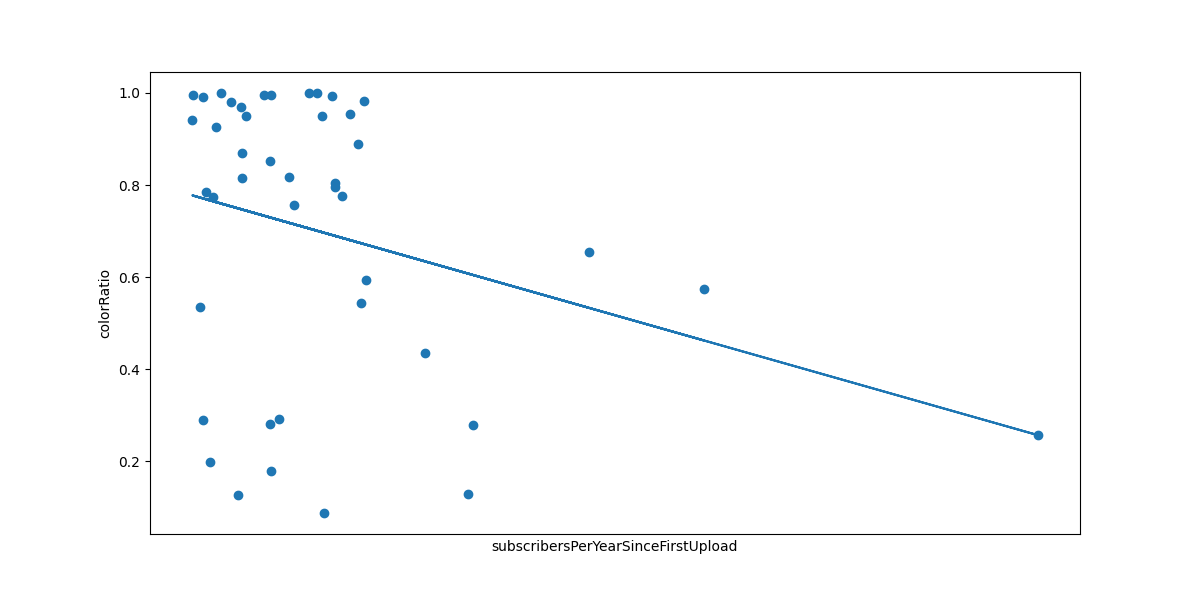

rvalue:  -0.3069150767103848


In [50]:
import mplcursors
import scipy

x_name = "subscribersPerYearSinceFirstUpload"
y_name = "colorRatio"
tooltip_name = "channelName"
x = vidIdToFramesListAndStatsDf[x_name]
y= vidIdToFramesListAndStatsDf[y_name]

tt = vidIdToFramesListAndStatsDf[tooltip_name]

zipped = zip(x, y)
sorted_vidId_to_validRatio = dict(sorted(dict(zipped).items(), key=lambda item: item[1]))

fig, ax = plt.subplots(1, figsize=(12,6))
sc = ax.scatter(sorted_vidId_to_validRatio.keys(), sorted_vidId_to_validRatio.values())
# # Plot the average line
# avg_score= vidIdToFramesListAndStatsDf[y_name].mean()
# mean_x=np.arange(0,43,1)
# mean_y=[avg_score for i in np.zeros_like(x)]
# mean_line = ax.plot(mean_x,mean_y, label='Mean', linestyle='--')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
cursor = mplcursors.cursor(sc, hover=True)
cursor.connect(
"add", lambda sel: sel.annotation.set_text(tt[sel.index]))
plt.xlabel(x_name)
plt.ylabel(y_name)

result = scipy.stats.linregress(x, y)
m=result.slope
b=result.intercept
plt.plot([i for i in x], [m*i + b for i in x])
plt.show()

print("rvalue: ", result.rvalue)

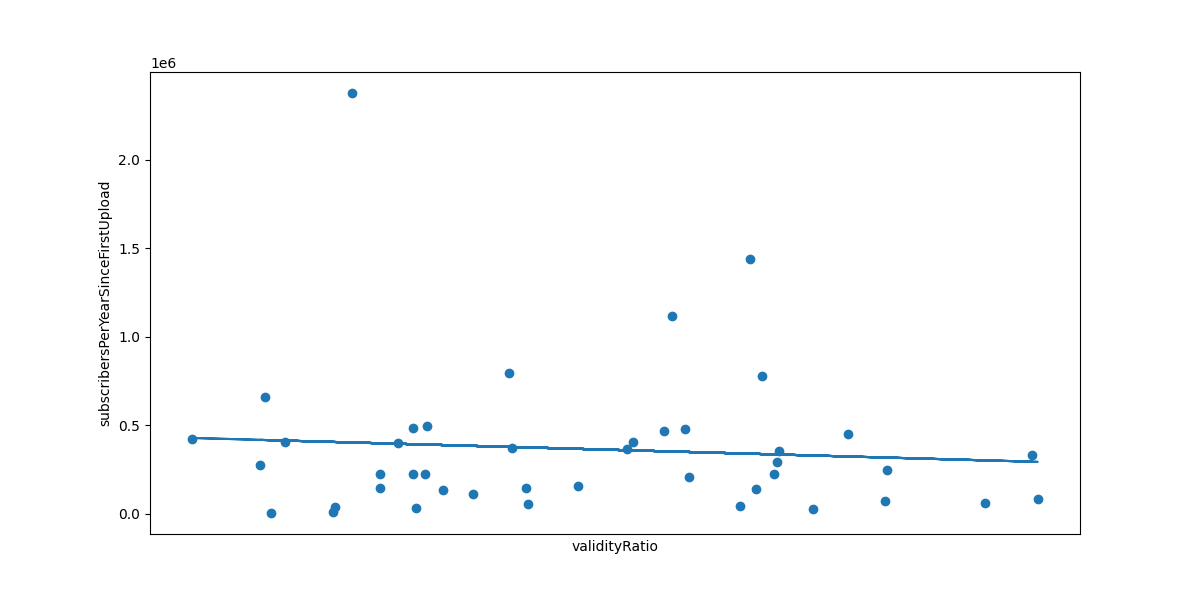

rvalue:  -0.08423496082267413


In [54]:
import mplcursors
import scipy

x_name = "validityRatio"
y_name = "subscribersPerYearSinceFirstUpload"
tooltip_name = "channelName"
x = [float(i) for i in vidIdToFramesListAndStatsDf[x_name]]
y= [float(i) for i in vidIdToFramesListAndStatsDf[y_name]]

tt = vidIdToFramesListAndStatsDf[tooltip_name]

zipped = zip(x, y)
sorted_vidId_to_validRatio = dict(sorted(dict(zipped).items(), key=lambda item: item[1]))
# tt = df[tooltip_name]

fig, ax = plt.subplots(1, figsize=(12,6))
sc = ax.scatter(x,y)
# # Plot the average line
# avg_score= vidIdToFramesListAndStatsDf[y_name].mean()
# mean_x=np.arange(0,43,1)
# mean_y=[avg_score for i in np.zeros_like(x)]
# mean_line = ax.plot(mean_x,mean_y, label='Mean', linestyle='--')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
cursor = mplcursors.cursor(sc, hover=True)
cursor.connect(
"add", lambda sel: sel.annotation.set_text(tt[sel.index]))
plt.xlabel(x_name)
plt.ylabel(y_name)

result = scipy.stats.linregress(x, y)
m=result.slope
b=result.intercept
plt.plot([i for i in x], [m*i + b for i in x])
plt.show()

print("rvalue: ", result.rvalue)

In [62]:
import scipy
import numpy as np

x= 'validityRatio'	
y= 'subscribersPerYearSinceFirstUpload'
result = scipy.stats.linregress([float(i) for i in vidIdToFramesListAndStatsDf[x]], [float(i) for i in vidIdToFramesListAndStatsDf[y]])
ssim_mean = scipy.stats.linregress([i['mean'] for i in vidIdToFramesListAndStatsDf['ssim']], vidIdToFramesListAndStatsDf[y])
mse_mean = scipy.stats.linregress([i['mean'] for i in vidIdToFramesListAndStatsDf['mse']], vidIdToFramesListAndStatsDf[y])
ssim_std = scipy.stats.linregress([i['std'] for i in vidIdToFramesListAndStatsDf['ssim']], vidIdToFramesListAndStatsDf[y])
mse_std = scipy.stats.linregress([i['std'] for i in vidIdToFramesListAndStatsDf['mse']], vidIdToFramesListAndStatsDf[y])

print("vanilla: ", 'rvalue:{}, pvalue:{}'.format(result.rvalue, result.pvalue))
print("ssim_mean: ", 'rvalue:{}, pvalue:{}'.format(ssim_mean.rvalue, ssim_mean.pvalue))
print("mse_mean: ", 'rvalue:{}, pvalue:{}'.format(mse_mean.rvalue, mse_mean.pvalue))
print("ssim_std: ", 'rvalue:{}, pvalue:{}'.format(ssim_std.rvalue, ssim_std.pvalue))
print("mse_std: ", 'rvalue:{}, pvalue:{}'.format(mse_std.rvalue, mse_std.pvalue))
print()

vanilla:  rvalue:-0.08423496082267413, pvalue:0.5912365142910356
ssim_mean:  rvalue:0.008247001215128556, pvalue:0.9581410617027556
mse_mean:  rvalue:0.008247001215128556, pvalue:0.9581410617027556
ssim_std:  rvalue:0.01955108591928592, pvalue:0.9009676914191367
mse_std:  rvalue:0.01955108591928592, pvalue:0.9009676914191367

